In [1]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

root_path = Path("/home/olivieri/exp").resolve()
src_path = root_path / "src"
sys.path.append(f"{str(src_path)}")

In [2]:
from IPython.display import Markdown
from concurrent.futures import ThreadPoolExecutor, as_completed # for paralellism
import time

from prompter import *
from data import *
from utils import *
from model import GoogleAIStudio

# Inference

In [3]:
# VLM
vlm = GoogleAIStudio(model="gemini-2.0-flash")

# Setting
BY_MODEL = "LRASPP_MobileNet_V3"
IMAGE_RESIZING_MODE = "letterboxed"
OUTPUT_MODE = "freeform"
SPLIT_BY = "non-splitted"

promptBuilder = PromptBuilder(
    by_model            = BY_MODEL,
    alpha               = 0.8,
    image_resizing_mode = IMAGE_RESIZING_MODE,
    output_mode         = OUTPUT_MODE,
    image_size          = (520, 520),
    array_size          = (32, 32),
    class_map           = CLASS_MAP, # imported from 'class_map.py'
    color_map           = COLOR_MAP_DICT,
    split_by            = SPLIT_BY
)

## Single Sample

In [4]:
promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = Names_ColorMapModule(variation="default"),
    input_format_module     = ConcatMasks_Sc_Hz_InputFormatModule("original"),
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=()),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="7_incomplet+strict+precision+error_types+spatial_locs")
)

In [5]:
query_idx = 0

I am in a multi-class semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**. The scene, the ground truth and the prediction have been letterboxed to have the same dimension.


In the masks, the classes are mapped to a specific color as defined by a color map, which is shared by both masks. The padding areas due to the letterboxing are by default segmented as '__BACKGROUND__' by the ground truth. What follows is a mapping between class names, class identifiers and colors.

{'BACKGROUND [0]': 'black', 'AEROPLANE [1]': 'maroon', 'BYCICLE [2]': 'green', 'BIRD [3]': 'olive', 'BOAT [4]': 'navy', 'BOTTLE [5]': 'purple', 'BUS [6]': 'teal', 'CAR [7]': 'gray', 'CAT [8]': 'darkmaroon', 'CHAIR [9]': 'firebrick', 'COW [10]': 'forestgreen', 'DININGTABLE [11]': 'darkgoldenrod', 'DOG [12]': 'indigo', 'HORSE [13]': 'mediumvioletred', 'MOTORBIKE [14]': 'seagreen', 'PERSON [15]': 'rosybrown', 'POTTEDPLANT [16]': 'darkgreen', 'SHEEP [17]': 'saddlebrown', 'SOFA [18]': 'lime', 'TRAIN [19]': 'yellowgreen', 'TVMONITOR [20]': 'midnightblue'}

I will give you an image which concatenates horizontally the scene, the ground truth and the prediction, which are displayed side-by-side.
The scene, the ground truth and the prediction are marked by the corresponding title above them.
In the whole image, the image on the left is the scene, the image on the center is the ground truth, and the image on the right is the prediction. Use the scene on the left to support your analysis.


## Instructions

Your task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.


I provide some examples of correct outputs:
- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the ground truth MOUNTAIN region on the center of the scene is incomplete."
- "The prediction mask is quite chaotic, many GRASS regions have been hallucinated all over the scene, while the TREE region has been over-extended towards the top."
- "The ground truth WATER region on the bottom has been segmented with a coarse, irregular shape, especially on the boundary."


Now, I ask you to generate the output based on following input.


Input:

Scene, Ground Truth and Prediction.

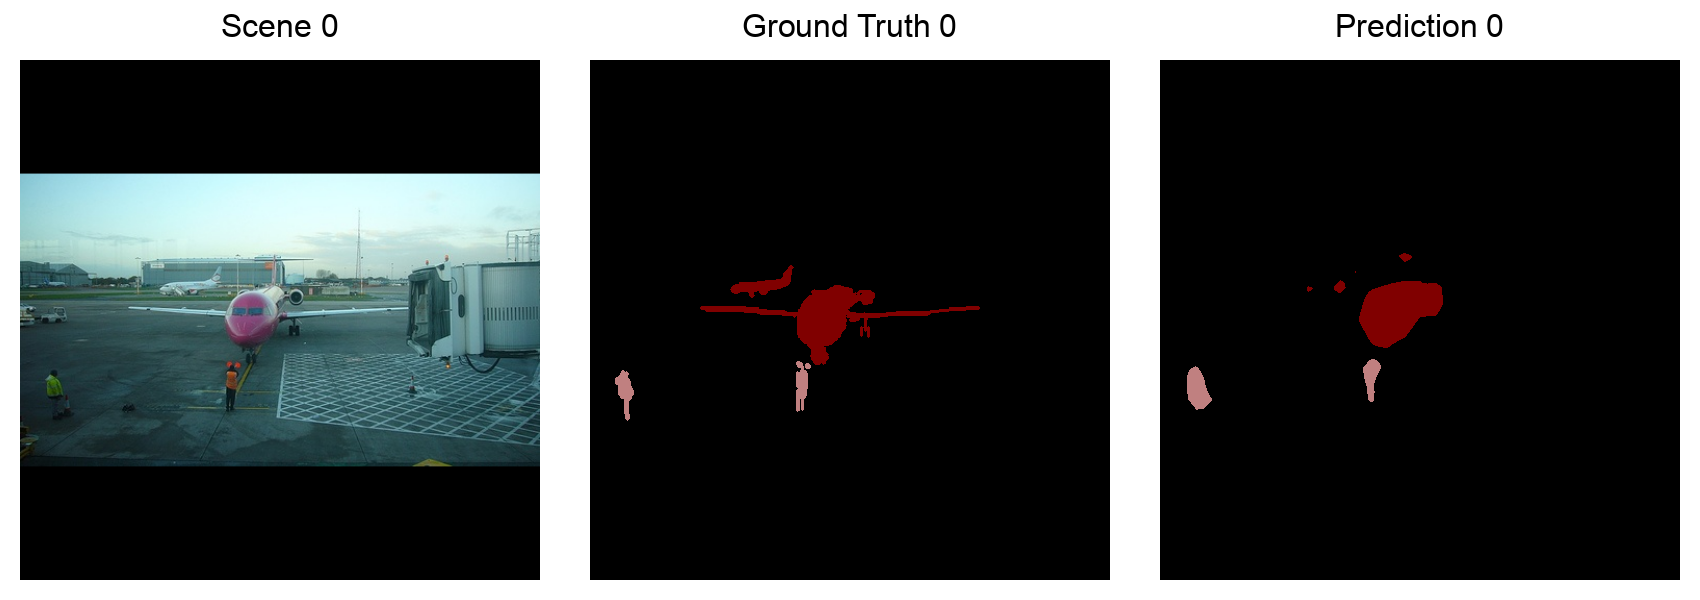

Output:

In [6]:
inference_prompt = promptBuilder.build_inference_prompt(query_idx)
display_prompt(inference_prompt)

In [10]:
answer_pr = vlm.predict_one(inference_prompt)
display(Markdown(answer_pr))

The prediction captured most of the ground truth AEROPLANE and PERSON regions, but the boundaries are slightly imprecise. The AEROPLANE region on the top left is missing in the prediction. The PERSON region on the bottom left is under-segmented.

In [11]:
eval_prompt = promptBuilder.build_eval_prompt(query_idx, answer_pr)

In [13]:
eval_pr = vlm.evaluate_one(eval_prompt, parse_to_dict=True)
eval_pr

{'pred': 'correct',
 'score': 4,
 'reason': "The predicted answer correctly identifies the main issues: the imprecise boundaries of the AEROPLANE and PERSON regions, the missing AEROPLANE region on the top left, and the under-segmentation of the PERSON region on the bottom left. While it doesn't capture every detail (like the hallucinated AEROPLANE patch), it accurately reflects the major discrepancies between the prediction and the ground truth."}

## Single-Format Batch

In [5]:
input_format = ArrayMasks_InputFormatModule("original")

promptBuilder.load_modules(
    context_module          = ContextModule(variation="default"),
    color_map_module        = Patches_ColorMapModule(variation="default"),
    input_format_module     = input_format,
    task_module             = TaskModule(variation="default"),
    output_format_module    = OutputFormatModule(variation="default"),
    support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16, 2, 18)),
    query_module            = QueryModule(variation="default"),
    eval_module             = EvalModule(variation="7_incomplet+strict+precision+error_types+spatial_locs")
)

epoch_eval_list = [{"state": promptBuilder.get_state()}]
# TODO remove null values from answers_prs in jsonl files

In [6]:
epoch_idxs = list(range(23))
epoch_idxs = [x for x in epoch_idxs if x not in promptBuilder.sup_set_idxs]
batches_idxs = partition_list(epoch_idxs, 7)
num_batches = len(batches_idxs)
batches_idxs

[[0, 1, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14], [15, 17, 19, 20, 21, 22]]

In [7]:
prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")
print(f"Evaluating {prompt_desc}.")
for i, batch_idxs in enumerate(batches_idxs):

    batch_eval_list = []

    with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
        future_to_idx = {executor.submit(lambda idx: vlm.predict_and_evaluate_one(promptBuilder, idx, parse_to_dict=True), query_idx): query_idx for query_idx in batch_idxs}
        for future in as_completed(future_to_idx):
            query_idx, eval_ = future.result()
            batch_eval_list.append({"img_idx": query_idx, "content": eval_})

    epoch_eval_list.extend(batch_eval_list)

    print(f"Batch {i+1}/{num_batches} completed.")

    time.sleep(60) if i < num_batches - 1 else None  # Sleep only if not the last batch

Evaluating ArrayMasks.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.


### Eval. Export

In [8]:
exp_name = f"test_class_split/non-splitted/{prompt_desc}"

exp_path = get_eval_prs_path(promptBuilder.by_model, promptBuilder.image_resizing_mode, promptBuilder.output_mode, "class-splitted", exp_name)

append_many_to_jsonl(exp_path, epoch_eval_list)

## Multi-Format Batch

In [65]:
all_epochs_eval_list = {}
prompt_desc_list = []

In [66]:
inputFormat_list = InputFormatModule.__subclasses__()
num_epochs = len(inputFormat_list)

In [67]:
inputFormat_list.remove(ArrayMasks_InputFormatModule)

In [68]:
for e, inputFormat in enumerate(inputFormat_list):

    input_format = inputFormat("original")

    promptBuilder.load_modules(
                context_module          = ContextModule(variation="default"),
                color_map_module        = Patches_ColorMapModule(variation="default"),
                input_format_module     = input_format,
                task_module             = TaskModule(variation="default"),
                output_format_module    = OutputFormatModule(variation="default"),
                support_set_module      = SupportSetModule(variation="default", sup_set_idxs=(16, 2, 18)),
                query_module            = QueryModule(variation="default"),
                eval_module             = EvalModule(variation="7_incomplet+strict+precision+error_types+spatial_locs")
            )

    epoch_eval_list = [{"state": promptBuilder.get_state()}]

    epoch_idxs = list(range(23))
    epoch_idxs = [x for x in epoch_idxs if x not in promptBuilder.sup_set_idxs]
    batches_idxs = partition_list(epoch_idxs, 7)
    num_batches = len(batches_idxs)

    prompt_desc = input_format.__class__.__name__.removesuffix("_InputFormatModule")
    
    print(f"Evaluating {prompt_desc}.")
    for i, batch_idxs in enumerate(batches_idxs):

        batch_eval_list = []

        with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust workers as needed
            future_to_idx = {executor.submit(lambda idx: vlm.predict_and_evaluate_one(promptBuilder, idx, parse_to_dict=True), query_idx): query_idx for query_idx in batch_idxs}
            for future in as_completed(future_to_idx):
                query_idx, eval_ = future.result()
                batch_eval_list.append({"img_idx": query_idx, "content": eval_})

        epoch_eval_list.extend(batch_eval_list)

        print(f"Batch {i+1}/{num_batches} completed.")

        time.sleep(60) if (i < num_batches - 1 or e < num_epochs - 1) else None  # Sleep only if not the last batch
    
    prompt_desc_list.append(prompt_desc)
    all_epochs_eval_list[prompt_desc] = epoch_eval_list

Evaluating ConcatMasks_Sc_Hz.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating ConcatMasks_Sc_Vr.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating ConcatMasks_Ovr_Hz.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating ConcatMasks_Ovr_Vr.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating ConcatMasks_NoSc_Hz.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating ConcatMasks_NoSc_Vr.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating SepMasks_NoSc.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating SepMasks_Ovr.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating SepMasks_Sc.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating ArrayMasks_Imgs.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3/3 completed.
Evaluating ArrayMasks_Imgs_Ovr.
Batch 1/3 completed.
Batch 2/3 completed.
Batch 3

In [60]:
all_epochs_eval_list.keys()

dict_keys(['ArrayMasks_Imgs_Ovr'])

In [69]:
for prompt_desc in prompt_desc_list:

    exp_name = f"test_class_split/non-splitted/{prompt_desc}"

    exp_path = get_eval_prs_path(promptBuilder.by_model, promptBuilder.image_resizing_mode, promptBuilder.output_mode, "class-splitted", exp_name)

    append_many_to_jsonl(exp_path, all_epochs_eval_list[prompt_desc])